In [20]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from PIL import Image
from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)
from utils.keypoints import get_gaussian_scoremap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple")

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
image_pose_result = pose_results[0]  # results for first image

for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Person #0
 - Nose: x=428.72, y=170.61, score=0.92
 - L_Eye: x=429.48, y=167.83, score=0.90
 - R_Eye: x=428.73, y=168.17, score=0.79
 - L_Ear: x=433.88, y=167.34, score=0.94
 - R_Ear: x=441.09, y=166.86, score=0.90
 - L_Shoulder: x=440.02, y=177.15, score=0.93
 - R_Shoulder: x=446.28, y=178.39, score=0.74
 - L_Elbow: x=436.88, y=197.89, score=0.92
 - R_Elbow: x=433.37, y=201.21, score=0.54
 - L_Wrist: x=431.45, y=218.65, score=0.88
 - R_Wrist: x=420.10, y=212.80, score=0.96
 - L_Hip: x=444.81, y=224.14, score=0.81
 - R_Hip: x=452.34, y=223.90, score=0.82
 - L_Knee: x=442.23, y=256.03, score=0.83
 - R_Knee: x=451.13, y=255.19, score=0.82
 - L_Ankle: x=443.19, y=288.17, score=0.60
 - R_Ankle: x=456.04, y=285.76, score=0.82
Person #1
 - Nose: x=398.12, y=181.71, score=0.87
 - L_Eye: x=398.45, y=179.74, score=0.82
 - R_Eye: x=396.07, y=179.45, score=0.90
 - R_Ear: x=388.85, y=180.22, score=0.88
 - L_Shoulder: x=397.24, y=194.16, score=0.76
 - R_Shoulder: x=384.60, y=190.74, score=0.64
 - L_

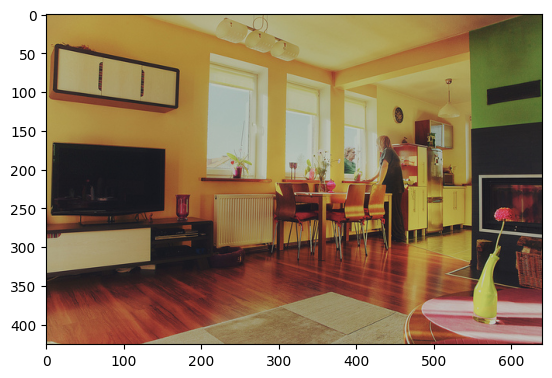

In [3]:
fig = plt.figure()
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.6988237].


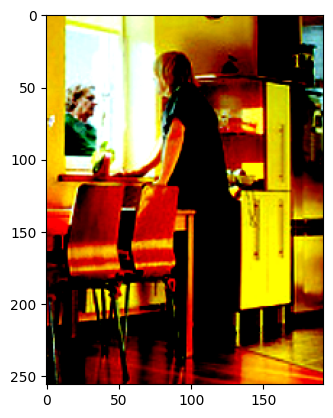

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..1.7511113].


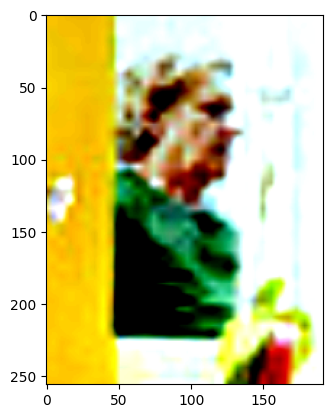

In [4]:
im = inputs['pixel_values'].permute(0,2,3,1)
plt.imshow(im[0])
plt.show()
plt.imshow(im[1])
plt.show()

In [5]:
print(model.head)

VitPoseSimpleDecoder(
  (activation): ReLU()
  (upsampling): Upsample(scale_factor=4.0, mode='bilinear')
  (conv): Conv2d(768, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.6988237].


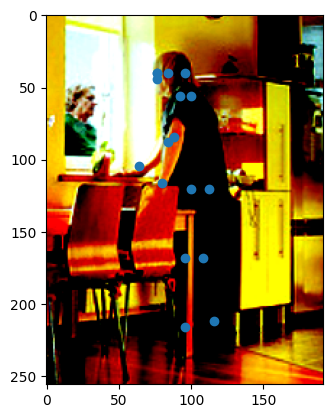

In [36]:
def extract_keypoints_from_heatmap(heatmap):
    """
    Extracts keypoint coordinates from predicted heatmaps.

    Args:
        heatmap: Tensor of shape (N_k, H, W)

    Returns:
        keypoints: List of (x, y) keypoints
    """
    N_k, H, W = heatmap.shape
    keypoints = []

    for i in range(N_k):
        # Get index of max value in heatmap
        idx = torch.argmax(heatmap[i])
        y, x = divmod(idx.item(), W)  # Convert to (y, x) coordinates
        keypoints.append((x, y))

    return keypoints

map = outputs.heatmaps[0]

kpts = extract_keypoints_from_heatmap(map)
kpts_list = []
for kp in kpts:
    kpts_list.append([kp[0], kp[1]])

kpts = np.array(kpts_list)*4

fig = plt.figure()
plt.imshow(im[0])
plt.scatter(x=kpts[:,0], y=kpts[:,1])
plt.show()

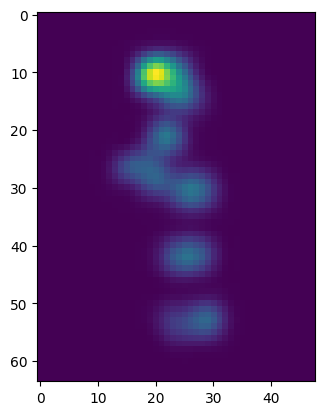

In [57]:
heatmap = torch.sum(map, dim=0)
fig = plt.figure()
plt.imshow(heatmap)
plt.show()

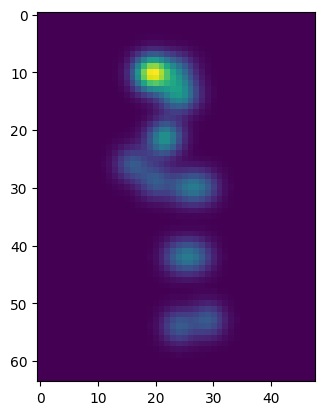

In [64]:
points = kpts/4
fig = plt.figure()
score_map_all = 0
for i in range(17):
    score_map = get_gaussian_scoremap((64,48), points[i], sigma=2)
    score_map_all += score_map
plt.imshow(score_map_all)
plt.show()

In [68]:
outputs

VitPoseEstimatorOutput(loss=None, heatmaps=tensor([[[[ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06],
          [ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06],
          [ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06],
          ...,
          [ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06],
          [ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06],
          [ 9.9330e-06,  9.9330e-06,  9.9330e-06,  ...,  9.9330e-06,
            9.9330e-06,  9.9330e-06]],

         [[-6.9340e-06, -6.9340e-06, -6.9340e-06,  ..., -6.9340e-06,
           -6.9340e-06, -6.9340e-06],
          [-6.9340e-06, -6.9340e-06, -6.9340e-06,  ..., -6.9340e-06,
           -6.9340e-06, -6.9340e-06],
          [-6.9340e-06, -6.9340e-06, -6.9340e-06,  ..., -6.9340e-06,
           -6.9